In [20]:
from typing import Annotated
from typing_extensions import TypedDict

In [21]:
import os
from dotenv import load_dotenv
load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")
os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LearningLanggraph"

In [22]:
from langchain_groq import ChatGroq
llm = ChatGroq(groq_api_key=groq_api_key, model="gemma2-9b-it")

In [23]:
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

wikipedia_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia_wrapper)

arxiv_wrapper = ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)


In [24]:
wikipedia_tool.invoke("who is narendra modi ?")

'Page: PM Narendra Modi\nSummary: PM Narendra Modi is a 2019 Hindi-language biographical drama film directed by Omung Kumar, and written by Anirudh Chawla and Vivek Oberoi. The film is jointly produced by Suresh Oberoi, Sandip Singh, Anand Pandit, Acharya Manish under the banner of Legend Studios. The'

In [25]:
arxiv_tool.invoke("Attention is all you need.")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [26]:
tools = [wikipedia_tool, arxiv_tool]

In [27]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [28]:
# Lang graph application

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [29]:
llm_with_tool = llm.bind_tools(tools)

In [30]:
from langgraph.prebuilt import ToolNode,tools_condition

In [31]:
tool_node = ToolNode(tools=tools)

In [32]:
def chatbot(state: State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
graph_builder.add_edge(
    "tools",
    "chatbot"
)
graph_builder.add_edge("chatbot", END)


In [33]:
graph = graph_builder.compile()

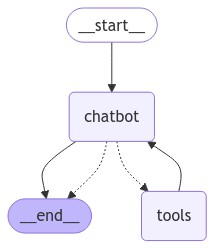

In [34]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [40]:
user_input = "explain transformer encoder decoder architecture"
events = graph.stream(
    {"messages": [("user", user_input)]},
    stream_mode="values"
    )

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

explain transformer encoder decoder architecture
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_345v)
 Call ID: call_345v
  Args:
    query: Transformer (machine learning)
================================= Tool Message =================================
Name: wikipedia

Page: Transformer (deep learning architecture)
Summary: A transformer is a deep learning architecture developed by researchers at Google and based on the multi-head attention mechanism, proposed in a 2017 paper "Attention Is All You Need". Text is converted to numerical representations called tokens
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_at8h)
 Call ID: call_at8h
  Args:
    query: multi-head attention mechanism
================================= Tool Message =================================
Name: wikipedia